In [29]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose


In [2]:
d = pd.read_csv("/Users/daron/Downloads/CTL Conversation Start Timestamps, 2015 and up, rounded down to nearest minute.csv - CTL Conversation Start Timestamps, 2015 and up, rounded down to nearest minute.csv.csv")

In [3]:
d.head()

,conv_start_est
0,2015-01-01 0:03:00
1,2015-01-01 0:07:00
2,2015-01-01 0:19:00
3,2015-01-01 0:24:00
4,2015-01-01 0:34:00


In [4]:
d.tail()

,conv_start_est
1119336,2017-08-27 3:18:00
1119337,2017-08-27 3:19:00
1119338,2017-08-27 3:19:00
1119339,2017-08-27 3:19:00
1119340,2017-08-27 3:20:00


In [5]:
d['ts'] = d['conv_start_est'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [6]:
d['month'] = d['ts'].apply(lambda x: x.month)

In [7]:
d['year'] = d['ts'].apply(lambda x: x.year)

In [8]:
d['dt'] = d['ts'].apply(lambda x: datetime(x.year, x.month, 1))

In [9]:
d['week_start'] = d['ts'].dt.to_period('W').apply(lambda r: r.start_time)

In [10]:
d.head()

,conv_start_est,ts,month,year,dt,week_start
0,2015-01-01 0:03:00,2015-01-01 00:03:00,1,2015,2015-01-01,2014-12-29
1,2015-01-01 0:07:00,2015-01-01 00:07:00,1,2015,2015-01-01,2014-12-29
2,2015-01-01 0:19:00,2015-01-01 00:19:00,1,2015,2015-01-01,2014-12-29
3,2015-01-01 0:24:00,2015-01-01 00:24:00,1,2015,2015-01-01,2014-12-29
4,2015-01-01 0:34:00,2015-01-01 00:34:00,1,2015,2015-01-01,2014-12-29


In [11]:
totals = d.groupby(['month', 'year']).count().reset_index()

In [12]:
totals = totals.sort_values(['year', 'month'])

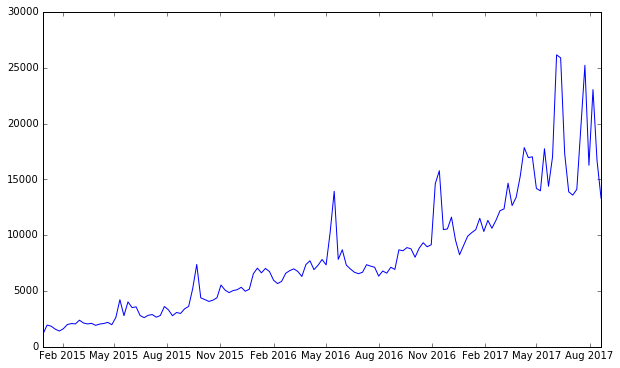

In [17]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot([x for x in tots.index], tots.flt)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'adj'

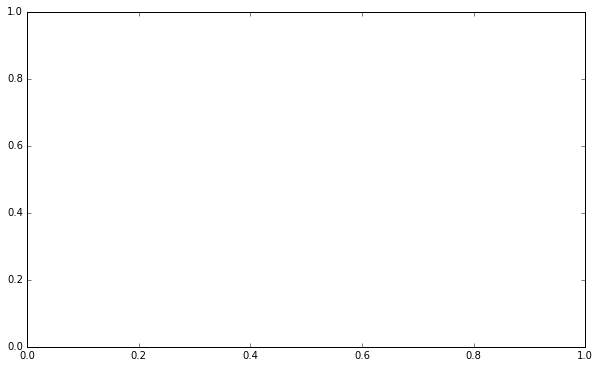

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
for x in totals.year.unique():
    df = totals[totals['year'] == x]
    ax.plot(df.month, df.adj)
plt.show()

In [52]:
totals['seq'] = range(len(totals))

In [15]:
# tots = d.groupby('dt').count()
tots = d.groupby('week_start').count()

In [16]:
tots['flt'] = tots['conv_start_est'].astype(float)

In [21]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

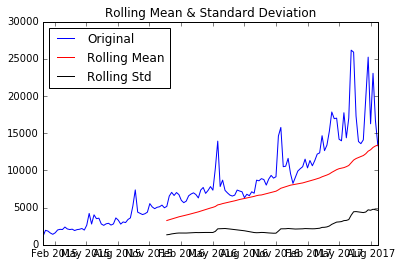

Results of Dickey-Fuller Test:
Test Statistic                   0.641584
p-value                          0.988597
#Lags Used                      11.000000
Number of Observations Used    127.000000
Critical Value (10%)            -2.579058
Critical Value (1%)             -3.482920
Critical Value (5%)             -2.884580
dtype: float64


In [24]:
test_stationarity(tots['flt'])

In [26]:
tots['lg'] = np.log(tots['flt'])

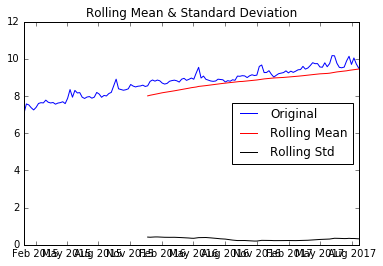

Results of Dickey-Fuller Test:
Test Statistic                  -1.502088
p-value                          0.532478
#Lags Used                       6.000000
Number of Observations Used    132.000000
Critical Value (10%)            -2.578586
Critical Value (1%)             -3.480888
Critical Value (5%)             -2.883697
dtype: float64


In [28]:
test_stationarity(tots['lg'])

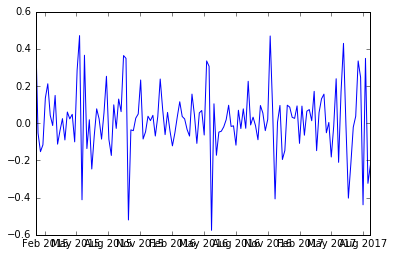

In [32]:
tots['diff'] = tots['lg'] - tots['lg'].shift()
plt.plot(tots['diff'])

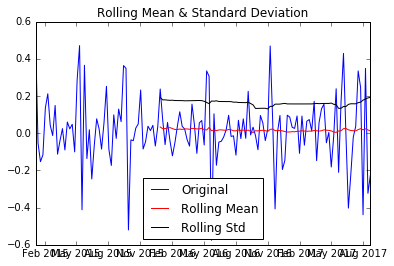

Results of Dickey-Fuller Test:
Test Statistic                -8.002974e+00
p-value                        2.307368e-12
#Lags Used                     5.000000e+00
Number of Observations Used    1.320000e+02
Critical Value (10%)          -2.578586e+00
Critical Value (1%)           -3.480888e+00
Critical Value (5%)           -2.883697e+00
dtype: float64


In [34]:
tots['diff'].dropna(inplace=True)
test_stationarity(tots['diff'])

In [161]:
model = ARIMA(tots['flt'], order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.flt   No. Observations:                  138
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1233.043
Method:                       css-mle   S.D. of innovations           1827.704
Date:                Tue, 29 Aug 2017   AIC                           2480.086
Time:                        21:11:46   BIC                           2500.577
Sample:                    01-05-2015   HQIC                          2488.413
                         - 08-21-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         123.2450     54.242      2.272      0.025      16.933     229.557
ar.L1.D.flt    -0.3671      0.080     -4.591      0.000      -0.524      -0.210
ar.L2.D.flt    -0.4463      0.083     -5.371    

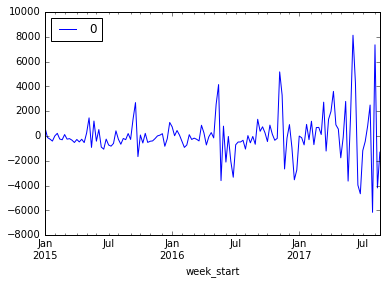

In [162]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

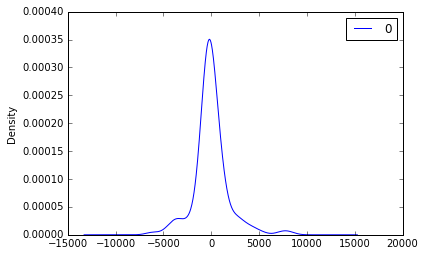

In [163]:
residuals.plot(kind='kde')

In [221]:
X = tots['flt']
size = int(len(X) * .9)
train, test = X[0:size], X[size:len(X)]
# test['2017-09-01'] = 60000
# test['2017-10-01'] = 70000
# test['2017-11-01'] = 80000
# test['2017-12-01'] = 90000
for q in range(17):
    test[datetime.strftime(date(2017,8,21)+timedelta(days=7*q+1), '%Y-%m-%d %H:%M:%S')] = 10000+q*500
history = [x for x in train]
predictions = list()
model = ARIMA(history, order=(5,1,0))
model_fit = model.fit(disp=0)
output = model_fit.forecast(steps=31)
for t in range(len(output[0])):
	yhat = output[0][t]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=17755.980670, expected=14382.000000
predicted=16994.000744, expected=17030.000000
predicted=17348.727771, expected=26160.000000
predicted=17363.594160, expected=25891.000000
predicted=16984.248632, expected=17306.000000
predicted=17363.331900, expected=13885.000000
predicted=17745.135392, expected=13593.000000
predicted=17767.134163, expected=14109.000000
predicted=17863.979993, expected=19719.000000
predicted=18044.570471, expected=25222.000000
predicted=18108.182151, expected=16266.000000
predicted=18201.770005, expected=23049.000000
predicted=18367.918608, expected=16681.000000
predicted=18500.821047, expected=13305.000000
predicted=18611.373055, expected=10000.000000
predicted=18743.836248, expected=10500.000000
predicted=18870.413518, expected=11000.000000
predicted=18986.018224, expected=11500.000000
predicted=19111.285390, expected=12000.000000
predicted=19240.089146, expected=12500.000000
predicted=19363.320433, expected=13000.000000
predicted=19487.443613, expected=1

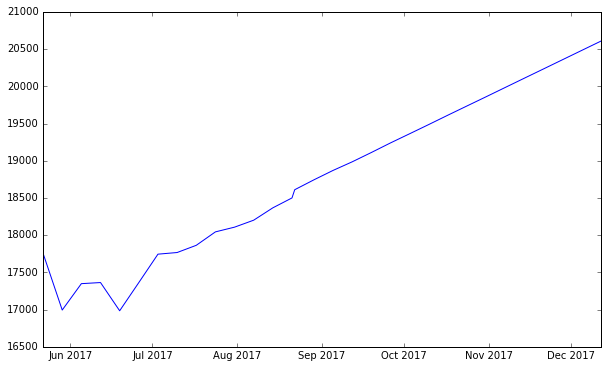

In [222]:
fig, ax = plt.subplots(figsize=(10,6))
# ax.plot([x for x in tots.index], tots['flt'])
# ax.plot([x for x in test[:4].index], test[:4])
# ax.plot([x for x in test.index], test)
ax.plot([x for x in test.index], predictions)
plt.show()

In [220]:
test

week_start
2017-05-22 00:00:00    14382.0
2017-05-29 00:00:00    17030.0
2017-06-05 00:00:00    26160.0
2017-06-12 00:00:00    25891.0
2017-06-19 00:00:00    17306.0
2017-06-26 00:00:00    13885.0
2017-07-03 00:00:00    13593.0
2017-07-10 00:00:00    14109.0
2017-07-17 00:00:00    19719.0
2017-07-24 00:00:00    25222.0
2017-07-31 00:00:00    16266.0
2017-08-07 00:00:00    23049.0
2017-08-14 00:00:00    16681.0
2017-08-21 00:00:00    13305.0
2017-08-22 00:00:00    10000.0
2017-08-29 00:00:00    10500.0
2017-09-05 00:00:00    11000.0
2017-09-12 00:00:00    11500.0
2017-09-19 00:00:00    12000.0
2017-09-26 00:00:00    12500.0
2017-10-03 00:00:00    13000.0
2017-10-10 00:00:00    13500.0
2017-10-17 00:00:00    14000.0
2017-10-24 00:00:00    14500.0
2017-10-31 00:00:00    15000.0
2017-11-07 00:00:00    15500.0
2017-11-14 00:00:00    16000.0
2017-11-21 00:00:00    16500.0
2017-11-28 00:00:00    17000.0
2017-12-05 00:00:00    17500.0
2017-12-12 00:00:00    18000.0
Name: flt, dtype: float64

In [191]:
datetime.strftime(date(2017,8,21)+timedelta(days=7*18), '%Y-%m-%d %H:%M:%S')

'2017-12-25 00:00:00'

In [109]:
output

(array([ 69692.34518519]),
 array([ 4881.72681215]),
 array([[ 60124.33645101,  79260.35391937]]))

In [120]:
test

dt
2017-05-01 00:00:00    68759.0
2017-06-01 00:00:00    88008.0
2017-07-01 00:00:00    79142.0
2017-08-01 00:00:00    66610.0
2017-09-01                 0.0
Name: flt, dtype: float64

In [136]:
[x for x in train.index]

[Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-02-01 00:00:00'),
 Timestamp('2015-03-01 00:00:00'),
 Timestamp('2015-04-01 00:00:00'),
 Timestamp('2015-05-01 00:00:00'),
 Timestamp('2015-06-01 00:00:00'),
 Timestamp('2015-07-01 00:00:00'),
 Timestamp('2015-08-01 00:00:00'),
 Timestamp('2015-09-01 00:00:00'),
 Timestamp('2015-10-01 00:00:00'),
 Timestamp('2015-11-01 00:00:00'),
 Timestamp('2015-12-01 00:00:00'),
 Timestamp('2016-01-01 00:00:00'),
 Timestamp('2016-02-01 00:00:00'),
 Timestamp('2016-03-01 00:00:00'),
 Timestamp('2016-04-01 00:00:00'),
 Timestamp('2016-05-01 00:00:00'),
 Timestamp('2016-06-01 00:00:00'),
 Timestamp('2016-07-01 00:00:00'),
 Timestamp('2016-08-01 00:00:00'),
 Timestamp('2016-09-01 00:00:00'),
 Timestamp('2016-10-01 00:00:00'),
 Timestamp('2016-11-01 00:00:00'),
 Timestamp('2016-12-01 00:00:00'),
 Timestamp('2017-01-01 00:00:00'),
 Timestamp('2017-02-01 00:00:00'),
 Timestamp('2017-03-01 00:00:00'),
 Timestamp('2017-04-01 00:00:00')]

In [190]:
test

week_start
2017-05-22 00:00:00     14382.0
2017-05-29 00:00:00     17030.0
2017-06-05 00:00:00     26160.0
2017-06-12 00:00:00     25891.0
2017-06-19 00:00:00     17306.0
2017-06-26 00:00:00     13885.0
2017-07-03 00:00:00     13593.0
2017-07-10 00:00:00     14109.0
2017-07-17 00:00:00     19719.0
2017-07-24 00:00:00     25222.0
2017-07-31 00:00:00     16266.0
2017-08-07 00:00:00     23049.0
2017-08-14 00:00:00     16681.0
2017-08-21 00:00:00     13305.0
2017-08-22              70000.0
2017-08-29              80000.0
2017-09-05              90000.0
2017-09-12             100000.0
2017-09-19             110000.0
2017-09-26             120000.0
2017-10-03             130000.0
2017-10-10             140000.0
2017-10-17             150000.0
2017-10-24             160000.0
2017-10-31             170000.0
2017-11-07             180000.0
2017-11-14             190000.0
2017-11-21             200000.0
2017-11-28             210000.0
2017-12-05             220000.0
2017-12-12             230000